# Neural Network Learning

Initial imports

In [19]:
import numpy as np
import nnfs
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data
from nnfs.datasets import sine_data
nnfs.init()

Neural network layer class

In [20]:
class Layer_Dense:
    
    # Neuron initialization
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1 = 0, weight_regularizer_l2 = 0, bias_regularizer_l1 = 0, bias_regularizer_l2 = 0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength / Lambda hyperperameters for penalties
        self.weight_regularizer_l1 = weight_regularizer_l1 
        self.weight_regularizer_l2 = weight_regularizer_l2 
        self.bias_regularizer_l1 = bias_regularizer_l1 
        self.bias_regularizer_l2 = bias_regularizer_l2 

    # Neuron forward pass for calculations
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass for derivative backpropagation
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

Rectified Linear Unit (ReLU) activation function

In [21]:
class Activation_ReLU:
    
    # Forward pass for output calculations
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    # Backward pass for derivative backpropagation
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

Softmax Activation function

In [22]:
class Activation_Softmax:
    
    # Forward pass for output
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    # Backward pass for derivative backpropagation
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

Sigmoid Activation function

In [23]:
class Activation_Sigmoid:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

Linear Activation function

In [24]:
class Activation_Linear:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

Loss parent class

In [25]:
class Loss:
    
    # Regularization loss calculation
    def regularization_loss(self, layer):
        regularization_loss = 0

        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss

    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

Cross Entropy Loss function

In [26]:
class Loss_CategorialCrossentropy(Loss):

    # Forward pass for loss calculation output
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis = 1)
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    # Backward pass for derivative backpropagation
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

Combined softmax activation and cross entropy loss for faster backward step

In [27]:
class Activation_Softmax_Loss_CategorialCrossentropy():


    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategorialCrossentropy()

    
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

Binary Cross-Entropy Loss Class

In [28]:
class Loss_BinaryCrossentropy(Loss):

    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples

Mean Squared Error Loss Class

In [29]:
class Loss_MeanSquaredError(Loss):

    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred) ** 2, axis = -1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

Mean Absolute Error Loss

In [30]:
class Loss_MeanAbsoluteError(Loss):

    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis = -1)
        return sample_losses
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

Stochastic Gradient Descent with Momentum Optimizer Class

In [31]:
class Optimizer_SGD:

    # Gradient descent optimizer initialization
    def __init__(self, learning_rate = 1.0, decay = 0, momentum = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Learning rate decay
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))


    # Parameter updater
    def update_params(self, layer):
        if self.momentum:

            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    
    def post_update_params(self):
        self.iterations += 1

Adagrad Optimizer Class

In [32]:
class Optimizer_Adagrad:


    def __init__(self, learning_rate = 1, decay = 0, epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))


    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache += layer.dweights ** 2

        layer.bias_cache += layer.dbiases ** 2

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)

        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    
    def post_update_params(self):
        self.iterations += 1

RMSProp Optimizer Class

In [33]:
class Optimizer_RMSprop:


    def __init__(self, learning_rate = 0.001, decay = 0, epsilon = 1e-7, rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho


    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))


    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2

        layer.weights += -self.current_learning_rate *  layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon) 
        layer.biases += -self.current_learning_rate *  layer.dbiases /  (np.sqrt(layer.bias_cache) + self.epsilon) 

    
    def post_update_params(self):
        self.iterations += 1

Adam (Adaptive Momentum) Optimizer Class

In [34]:
class Optimizer_Adam:


    def __init__(self, learning_rate = 0.001, decay = 0, epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate 
        self.current_learning_rate = learning_rate 
        self.decay = decay 
        self.iterations = 0 
        self.epsilon = epsilon 
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 


    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))

    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)


    def post_update_params(self):
        self.iterations += 1

Dropout Layer

In [35]:
class Layer_Dropout:
    
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

Neural Network Model Object Class

In [ ]:
class Model:

    # Model initializer
    def __init__(self):
        self.layers = []

    # Adds layers
    def add(self, layer):
        self.layers.append(layer)

    # Sets the loss and optimizer functions and parameters
    def set(self, *, loss, optimizer):
        self.loss = loss
        self.optimizer = optimizer

    # Trains the model
    def train(self, X, y, *, epochs=1, print_every=1):
        for epoch in range(1, epochs+1):
            pass

Model Training

In [38]:
X, y = sine_data()

dense1 = Layer_Dense(1, 64)

activation1 = Activation_ReLU()

dense2 = Layer_Dense(64, 64)

activation2 = Activation_ReLU()

dense3 = Layer_Dense(64, 1)

activation3 = Activation_Linear()

loss_function = Loss_MeanSquaredError()

optimizer = Optimizer_Adam()

accuracy_precision = np.std(y) / 250

for epoch in range(10001): 

    dense1.forward(X) 
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)

    data_loss = loss_function.calculate(activation3.output, y)

    regularization_loss = loss_function.regularization_loss(dense1) + loss_function.regularization_loss(dense2) + loss_function.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = activation3.output

    accuracy = np.mean(np.absolute(predictions - y) < accuracy_precision)
 
    if epoch % 100 == 0: 
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f} (' + 
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' + 
              f'lr: {optimizer.current_learning_rate}')
 
    loss_function.backward(activation3.output, y) 
    activation3.backward(loss_function.dinputs) 
    dense3.backward(activation3.dinputs) 
    activation2.backward(dense3.dinputs) 
    dense2.backward(activation2.dinputs) 
    activation1.backward(dense2.dinputs) 
    dense1.backward(activation1.dinputs)  
  
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.002, loss: 0.500 (data_loss: 0.500, reg_loss: 0.000), lr: 0.001
epoch: 100, acc: 0.004, loss: 0.164 (data_loss: 0.164, reg_loss: 0.000), lr: 0.001
epoch: 200, acc: 0.006, loss: 0.111 (data_loss: 0.111, reg_loss: 0.000), lr: 0.001
epoch: 300, acc: 0.005, loss: 0.093 (data_loss: 0.093, reg_loss: 0.000), lr: 0.001
epoch: 400, acc: 0.007, loss: 0.073 (data_loss: 0.073, reg_loss: 0.000), lr: 0.001
epoch: 500, acc: 0.011, loss: 0.058 (data_loss: 0.058, reg_loss: 0.000), lr: 0.001
epoch: 600, acc: 0.082, loss: 0.039 (data_loss: 0.039, reg_loss: 0.000), lr: 0.001
epoch: 700, acc: 0.161, loss: 0.020 (data_loss: 0.020, reg_loss: 0.000), lr: 0.001
epoch: 800, acc: 0.161, loss: 0.009 (data_loss: 0.009, reg_loss: 0.000), lr: 0.001
epoch: 900, acc: 0.236, loss: 0.004 (data_loss: 0.004, reg_loss: 0.000), lr: 0.001
epoch: 1000, acc: 0.363, loss: 0.002 (data_loss: 0.002, reg_loss: 0.000), lr: 0.001
epoch: 1100, acc: 0.526, loss: 0.001 (data_loss: 0.001, reg_loss: 0.000), lr: 0.001
epoc

Model Testing

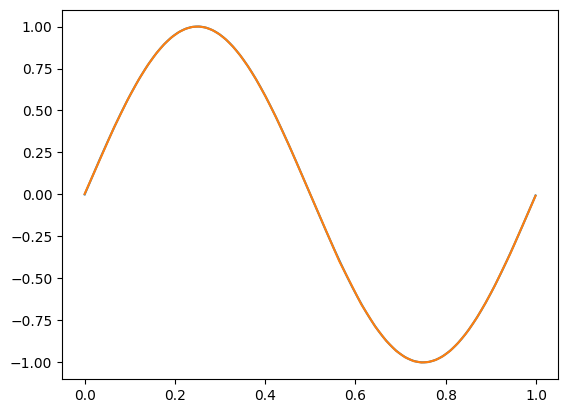

In [46]:
X_test, y_test = sine_data()

dense1.forward(X_test) 
activation1.forward(dense1.output) 
dense2.forward(activation1.output) 
activation2.forward(dense2.output) 

plt.plot(X_test, y_test) 
plt.plot(X_test, activation3.output) 
plt.show() 